#Klasifikasi Jamur Menggunakan Genetic Algorithm dan ANN

- Muhamad Febrian Soambaton
- Wildan
- Amal
- Raihan


##Import Library, dataset, dan fungsi-fungsi:

###Library:

In [1]:
ilotlib.pyplot as plt
import warnings
import randommport pandas as pd
import numpy as np
import seaborn as sns
import matp

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files, drive

warnings.filterwarnings('ignore')
np.random.seed(69420)
random.seed(69420)

###Memasukkan Dataset:

In [ ]:
#Jika mengupload file dari local
files.upload()

In [3]:
#Jika file ada di google drive (dataset disimpan pada direktori "Semester 6/Sisdas/data/mushrooms.csv")
drive.mount('/content/drive')

Mounted at /content/drive


###Fungsi-Fungsi:

In [4]:
########################

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def forward(x, w, activation):
    return activation(np.matmul(x, w))

def accuracy_fn(y, y_hat):
    return (np.where(y == y_hat)[0].size / y_hat.size)

def predict(x, y_hat, weights, activation):
    predictions = np.zeros(shape=(x.shape[0]))

    for idx in range(x.shape[0]):
        r1 = x[idx, :]
        for curr_weights in weights:
            r1 = forward(r1, curr_weights, activation)
        predictions[idx] = np.where(r1 == np.max(r1))[0][0]

    accuracy = accuracy_fn(predictions, y_hat)
    return accuracy, predictions

def fitness(x, y_hat, weights, activation):
    accuracy = np.empty(shape=(weights.shape[0]))
    for idx in range(weights.shape[0]):
        accuracy[idx], _ = predict(x, y_hat, weights[idx, :], activation)
    return accuracy

def mat_to_vector(mat_pop_weights):
    weights_vector = []
    for idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[idx, layer_idx], newshape=(mat_pop_weights[idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        weights_vector.append(curr_vector)
    return np.array(weights_vector)


def vector_to_mat(vector_weights, mat_pop_weights):
    mat_weights = []
    for idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[idx, layer_idx].size
            curr_vector = vector_weights[idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

def mating_pool(pop, fitness, num_parents):
    print("pop shape")
    print(pop.shape)
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint32(offspring_size[1]/2)

    print("looping berapa kali")
    print(offspring_size[0])

    print("parent shape")
    print(parents.shape)

    for k in range(offspring_size[0]):
        # 0, 1 | 1, 2 | 2, 3 | 3, 0

        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]

        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]

    return offspring


def mutation(offspring_crossover, mutation_percent):
    num_mutations = np.uint32((mutation_percent*offspring_crossover.shape[1]))
    mutation_indices = np.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))

    for idx in range(offspring_crossover.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, 1) # kenapa uniform ? biar ga dapet nilai pengurangan/penjumlahan yang besar
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value

    return offspring_crossover

##############################

In [5]:
np.random.uniform(-1.0, 1.0, 1)

array([0.06218448])

###Membaca dataset:

In [6]:
#Jika file diuload dari local
df = pd.read_csv('/content/Mushroom.csv', na_values="?")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [8]:
#Jika file berada di drive
df = pd.read_csv('/content/Mushroom.csv', na_values="?")
df.head

<bound method NDFrame.head of      class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0        p         x           s         n       t    p               f   
1        e         x           s         y       t    a               f   
2        e         b           s         w       t    l               f   
3        p         x           y         w       t    p               f   
4        e         x           s         g       f    n               f   
...    ...       ...         ...       ...     ...  ...             ...   
8119     e         k           s         n       f    n               a   
8120     e         x           s         n       f    n               a   
8121     e         f           s         n       f    n               a   
8122     p         k           y         n       f    y               f   
8123     e         x           s         n       f    n               a   

     gill-spacing gill-size gill-color  ... stalk-surface-below-ring 

##Pra-proses:

In [9]:
#Ambil target
target = df['class']

#Merubah missing value menjadi modus
df['stalk-root'].fillna(df['stalk-root'].mode()[0], inplace=True)

#Merubah data kategorik kedalam bentuk angka
encoder = LabelEncoder()
df_encoded = df.iloc[:, 1:]
cols = df_encoded.columns.values
for col in cols:
    # print(df[col].unique())
    df_encoded[col] = encoder.fit_transform(df_encoded[col])

target_encoded = encoder.fit_transform(target)

df_encoded.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1


##Klasifikasi:

Processing mutation_percent = 0.1:   7%|▋         | 1/15 [00:03<00:52,  3.73s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  13%|█▎        | 2/15 [00:07<00:48,  3.72s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  20%|██        | 3/15 [00:11<00:44,  3.74s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  27%|██▋       | 4/15 [00:14<00:39,  3.61s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  33%|███▎      | 5/15 [00:17<00:34,  3.42s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  40%|████      | 6/15 [00:21<00:31,  3.52s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  47%|████▋     | 7/15 [00:25<00:29,  3.63s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  53%|█████▎    | 8/15 [00:28<00:24,  3.56s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  60%|██████    | 9/15 [00:32<00:21,  3.54s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  67%|██████▋   | 10/15 [00:35<00:17,  3.48s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  73%|███████▎  | 11/15 [00:39<00:14,  3.53s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  80%|████████  | 12/15 [00:42<00:10,  3.59s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  87%|████████▋ | 13/15 [00:46<00:07,  3.65s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.1:  93%|█████████▎| 14/15 [00:49<00:03,  3.45s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:   7%|▋         | 1/15 [00:03<00:47,  3.37s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  13%|█▎        | 2/15 [00:07<00:47,  3.62s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  20%|██        | 3/15 [00:10<00:43,  3.66s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  27%|██▋       | 4/15 [00:13<00:37,  3.37s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  33%|███▎      | 5/15 [00:17<00:33,  3.33s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  40%|████      | 6/15 [00:20<00:30,  3.42s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  47%|████▋     | 7/15 [00:24<00:28,  3.55s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  53%|█████▎    | 8/15 [00:28<00:25,  3.61s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  60%|██████    | 9/15 [00:31<00:21,  3.59s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  67%|██████▋   | 10/15 [00:35<00:17,  3.49s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  73%|███████▎  | 11/15 [00:38<00:13,  3.37s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  80%|████████  | 12/15 [00:41<00:10,  3.48s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  87%|████████▋ | 13/15 [00:45<00:07,  3.54s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.2:  93%|█████████▎| 14/15 [00:48<00:03,  3.50s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:   7%|▋         | 1/15 [00:03<00:50,  3.61s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  13%|█▎        | 2/15 [00:07<00:46,  3.59s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  20%|██        | 3/15 [00:10<00:43,  3.65s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  27%|██▋       | 4/15 [00:14<00:37,  3.44s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  33%|███▎      | 5/15 [00:17<00:34,  3.41s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  40%|████      | 6/15 [00:20<00:29,  3.29s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  47%|████▋     | 7/15 [00:23<00:26,  3.33s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  53%|█████▎    | 8/15 [00:27<00:24,  3.48s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  60%|██████    | 9/15 [00:31<00:20,  3.46s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  67%|██████▋   | 10/15 [00:34<00:17,  3.43s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  73%|███████▎  | 11/15 [00:37<00:13,  3.43s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  80%|████████  | 12/15 [00:41<00:10,  3.38s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  87%|████████▋ | 13/15 [00:44<00:06,  3.49s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.3:  93%|█████████▎| 14/15 [00:48<00:03,  3.50s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:   7%|▋         | 1/15 [00:03<00:48,  3.47s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  13%|█▎        | 2/15 [00:06<00:44,  3.41s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  20%|██        | 3/15 [00:10<00:42,  3.55s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  27%|██▋       | 4/15 [00:14<00:39,  3.58s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  33%|███▎      | 5/15 [00:16<00:32,  3.27s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  40%|████      | 6/15 [00:20<00:29,  3.27s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  47%|████▋     | 7/15 [00:23<00:26,  3.27s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  53%|█████▎    | 8/15 [00:27<00:23,  3.39s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  60%|██████    | 9/15 [00:30<00:20,  3.50s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  67%|██████▋   | 10/15 [00:34<00:17,  3.49s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  73%|███████▎  | 11/15 [00:37<00:13,  3.45s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  80%|████████  | 12/15 [00:40<00:09,  3.33s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  87%|████████▋ | 13/15 [00:44<00:06,  3.42s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.4:  93%|█████████▎| 14/15 [00:48<00:03,  3.55s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:   7%|▋         | 1/15 [00:03<00:45,  3.26s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  13%|█▎        | 2/15 [00:06<00:40,  3.09s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  20%|██        | 3/15 [00:09<00:39,  3.29s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  27%|██▋       | 4/15 [00:13<00:38,  3.48s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  33%|███▎      | 5/15 [00:17<00:35,  3.54s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  40%|████      | 6/15 [00:20<00:31,  3.47s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  47%|████▋     | 7/15 [00:23<00:27,  3.42s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  53%|█████▎    | 8/15 [00:27<00:23,  3.39s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  60%|██████    | 9/15 [00:30<00:20,  3.48s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  67%|██████▋   | 10/15 [00:34<00:17,  3.52s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  73%|███████▎  | 11/15 [00:37<00:13,  3.46s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  80%|████████  | 12/15 [00:40<00:09,  3.27s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  87%|████████▋ | 13/15 [00:44<00:06,  3.38s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.5:  93%|█████████▎| 14/15 [00:48<00:03,  3.53s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:   7%|▋         | 1/15 [00:03<00:50,  3.62s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  13%|█▎        | 2/15 [00:06<00:44,  3.40s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  20%|██        | 3/15 [00:10<00:42,  3.54s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  27%|██▋       | 4/15 [00:14<00:40,  3.68s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  33%|███▎      | 5/15 [00:18<00:36,  3.66s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  40%|████      | 6/15 [00:21<00:31,  3.55s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  47%|████▋     | 7/15 [00:24<00:27,  3.40s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  53%|█████▎    | 8/15 [00:27<00:23,  3.29s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  60%|██████    | 9/15 [00:31<00:20,  3.44s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  67%|██████▋   | 10/15 [00:35<00:17,  3.55s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  73%|███████▎  | 11/15 [00:38<00:13,  3.49s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  80%|████████  | 12/15 [00:41<00:10,  3.47s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  87%|████████▋ | 13/15 [00:45<00:06,  3.37s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.6:  93%|█████████▎| 14/15 [00:48<00:03,  3.50s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:   7%|▋         | 1/15 [00:03<00:50,  3.58s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  13%|█▎        | 2/15 [00:06<00:45,  3.47s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  20%|██        | 3/15 [00:10<00:41,  3.43s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  27%|██▋       | 4/15 [00:14<00:39,  3.62s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  33%|███▎      | 5/15 [00:18<00:37,  3.73s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  40%|████      | 6/15 [00:21<00:33,  3.68s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  47%|████▋     | 7/15 [00:24<00:28,  3.52s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  53%|█████▎    | 8/15 [00:28<00:23,  3.40s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  60%|██████    | 9/15 [00:31<00:21,  3.53s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  67%|██████▋   | 10/15 [00:35<00:18,  3.60s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  73%|███████▎  | 11/15 [00:39<00:14,  3.57s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  80%|████████  | 12/15 [00:42<00:10,  3.36s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  87%|████████▋ | 13/15 [00:45<00:06,  3.35s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.7:  93%|█████████▎| 14/15 [00:49<00:03,  3.44s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:   7%|▋         | 1/15 [00:03<00:52,  3.77s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  13%|█▎        | 2/15 [00:07<00:45,  3.47s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  20%|██        | 3/15 [00:10<00:38,  3.24s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  27%|██▋       | 4/15 [00:13<00:37,  3.44s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  33%|███▎      | 5/15 [00:17<00:35,  3.59s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  40%|████      | 6/15 [00:20<00:31,  3.46s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  47%|████▋     | 7/15 [00:23<00:26,  3.28s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  53%|█████▎    | 8/15 [00:26<00:22,  3.23s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  60%|██████    | 9/15 [00:29<00:18,  3.16s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  67%|██████▋   | 10/15 [00:33<00:16,  3.33s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  73%|███████▎  | 11/15 [00:37<00:13,  3.47s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  80%|████████  | 12/15 [00:40<00:10,  3.36s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  87%|████████▋ | 13/15 [00:43<00:06,  3.34s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.8:  93%|█████████▎| 14/15 [00:47<00:03,  3.41s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:   7%|▋         | 1/15 [00:03<00:54,  3.86s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  13%|█▎        | 2/15 [00:07<00:46,  3.55s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  20%|██        | 3/15 [00:10<00:42,  3.50s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  27%|██▋       | 4/15 [00:13<00:37,  3.44s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  33%|███▎      | 5/15 [00:17<00:35,  3.55s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  40%|████      | 6/15 [00:21<00:32,  3.63s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  47%|████▋     | 7/15 [00:24<00:28,  3.53s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  53%|█████▎    | 8/15 [00:28<00:24,  3.45s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  60%|██████    | 9/15 [00:31<00:20,  3.34s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  67%|██████▋   | 10/15 [00:34<00:17,  3.45s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  73%|███████▎  | 11/15 [00:38<00:14,  3.53s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  80%|████████  | 12/15 [00:42<00:10,  3.60s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  87%|████████▋ | 13/15 [00:45<00:06,  3.45s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 0.9:  93%|█████████▎| 14/15 [00:48<00:03,  3.39s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:   7%|▋         | 1/15 [00:03<00:55,  3.96s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  13%|█▎        | 2/15 [00:06<00:42,  3.25s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  20%|██        | 3/15 [00:09<00:38,  3.21s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  27%|██▋       | 4/15 [00:12<00:34,  3.12s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  33%|███▎      | 5/15 [00:16<00:32,  3.21s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  40%|████      | 6/15 [00:19<00:30,  3.40s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  47%|████▋     | 7/15 [00:23<00:27,  3.45s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  53%|█████▎    | 8/15 [00:26<00:23,  3.42s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  60%|██████    | 9/15 [00:30<00:20,  3.35s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  67%|██████▋   | 10/15 [00:33<00:17,  3.45s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  73%|███████▎  | 11/15 [00:37<00:14,  3.54s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  80%|████████  | 12/15 [00:40<00:10,  3.50s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  87%|████████▋ | 13/15 [00:44<00:07,  3.51s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Processing mutation_percent = 1.0:  93%|█████████▎| 14/15 [00:47<00:03,  3.42s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


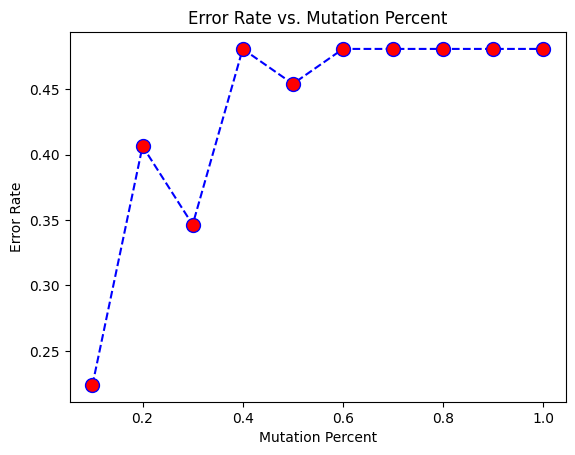

In [19]:
#Split data train dan test
x_train, x_test, y_train, y_test = train_test_split(df_encoded.to_numpy(), target_encoded, test_size = 0.20, random_state = 42)

#Parameter GA
solution_per_population = 8
num_parents_mating = 4
num_generations = 15

input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

# inisiasi weight
initial_weights = []
for curr_sol in np.arange(0, solution_per_population):

    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
    w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
    w3 = np.random.uniform(low=-0.1, high=0.1, size=(64, output_shape))

    initial_weights.append(np.array([w1, w2, w3]))

weights_mat = np.array(initial_weights)
weights_vector = mat_to_vector(weights_mat)

#Parameter penilaian
error_rate = []
accu_uyeh = []
best_outputs = []
accuracies = np.empty(shape=(num_generations))

# Pengujian model
for i in range(1,11):
  mutation_percent = i/10

  weights_mat = np.array(initial_weights)
  weights_vector = mat_to_vector(weights_mat)

  accuracies = np.empty(shape=(num_generations))
  for generation in tqdm(range(num_generations), desc="Processing mutation_percent = " + str(i/10), leave=False):

    # vector to matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)

    # fitness of the population
    fit = fitness(x_train, y_train, weights_mat, activation=sigmoid)

    # assign first fitness to the array
    accuracies[generation] = fit[0]

    # selecting mating parents from pool
    parents = mating_pool(weights_vector, fit.copy(), num_parents_mating)

    # generate new population using crossover
    offspring_crossover = crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))

    # adding mutation to the population
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)

    # new population combining parents of crossver and mut
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation

  weights_mat = vector_to_mat(weights_vector, weights_mat)
  best_weights = weights_mat [0, :]
  acc, predictions = predict(x_train, y_train, best_weights, sigmoid)
  error_rate.append(np.mean(predictions != y_train))
  accu_uyeh.append(acc)

#Plot
xDex = []
for i in range(1,11):
  xDex.append(i/10)

plt.plot(xDex, error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. Mutation Percent')
plt.xlabel('Mutation Percent')
plt.ylabel('Error Rate')
plt.show()

In [20]:
(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1])

(4, 11136)

In [21]:
weights_vector.shape

(8, 11136)

###Membuat model dengan mutation_percent terbaik:

In [22]:
#Split data train dan test
x_train, x_test, y_train, y_test = train_test_split(df_encoded.to_numpy(), target_encoded, test_size = 0.20, random_state = 42)

# Buat model dengan mutation_percent 0.1
solution_per_population = 8
num_parents_mating = 4
num_generations = 20
mutation_percent = 0.1

input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

# inisiasi weight
initial_weights = []
for curr_sol in np.arange(0, solution_per_population):

    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
    w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
    w3 = np.random.uniform(low=-0.1, high=0.1,size=(64, output_shape))

    initial_weights.append(np.array([w1, w2, w3]))

weights_mat = np.array(initial_weights)
weights_vector = mat_to_vector(weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

# training
for generation in tqdm(range(num_generations)):

    # vector to matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)

    # fitness of the population
    fit = fitness(x_train, y_train, weights_mat, activation=sigmoid)

    # assign first fitness to the array
    accuracies[generation] = fit[0]

    # selecting mating parents from pool
    parents = mating_pool(weights_vector, fit.copy(), num_parents_mating)

    # generate new population using crossover
    offspring_crossover = crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))

    # adding mutation to the population
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)

    # new population combining parents of crossver and mut
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation

weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_train, y_train, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

  5%|▌         | 1/20 [00:05<01:40,  5.29s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 10%|█         | 2/20 [00:09<01:19,  4.40s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 15%|█▌        | 3/20 [00:12<01:10,  4.14s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 20%|██        | 4/20 [00:16<01:01,  3.85s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 25%|██▌       | 5/20 [00:19<00:56,  3.76s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 30%|███       | 6/20 [00:23<00:52,  3.74s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 35%|███▌      | 7/20 [00:27<00:48,  3.73s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 40%|████      | 8/20 [00:31<00:44,  3.73s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 45%|████▌     | 9/20 [00:34<00:39,  3.63s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 50%|█████     | 10/20 [00:37<00:35,  3.55s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 55%|█████▌    | 11/20 [00:40<00:30,  3.36s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 60%|██████    | 12/20 [00:44<00:27,  3.40s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 65%|██████▌   | 13/20 [00:48<00:24,  3.54s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 70%|███████   | 14/20 [00:51<00:21,  3.57s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 75%|███████▌  | 15/20 [00:55<00:17,  3.50s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 80%|████████  | 16/20 [00:58<00:13,  3.46s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 85%|████████▌ | 17/20 [01:01<00:10,  3.35s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 90%|█████████ | 18/20 [01:05<00:07,  3.51s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


 95%|█████████▌| 19/20 [01:09<00:03,  3.59s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


100%|██████████| 20/20 [01:12<00:00,  3.62s/it]

pop shape
(8, 11136)
looping berapa kali
4
parent shape
(4, 11136)


Accuracy of the best solution is :  0.6708724419141406


###Plot Fitnes setiap iterasinya:

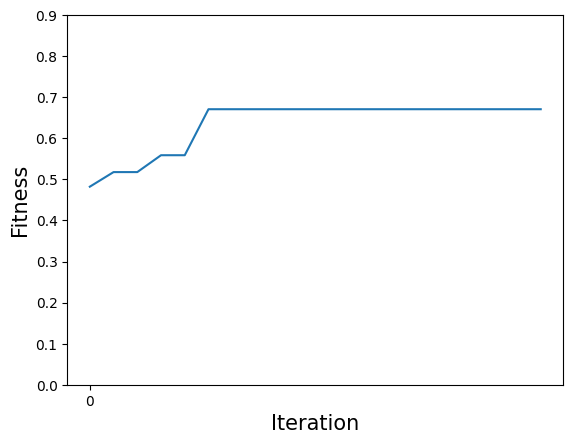

In [23]:
plt.plot(accuracies)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.xticks(np.arange(0, num_generations+1, 100))
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

###Cunfusion Matrix & Classification Report:

In [24]:
print(confusion_matrix(y_train,predictions))
print(classification_report(y_train,predictions))

[[2914  451]
 [1688 1446]]
              precision    recall  f1-score   support

           0       0.63      0.87      0.73      3365
           1       0.76      0.46      0.57      3134

    accuracy                           0.67      6499
   macro avg       0.70      0.66      0.65      6499
weighted avg       0.70      0.67      0.66      6499



##Prediksi data test

In [25]:
#Implementasi pada data test
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_test, y_test, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.656


###Cunfusion Matrix & Classification Report:

In [26]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[710 133]
 [426 356]]
              precision    recall  f1-score   support

           0       0.62      0.84      0.72       843
           1       0.73      0.46      0.56       782

    accuracy                           0.66      1625
   macro avg       0.68      0.65      0.64      1625
weighted avg       0.67      0.66      0.64      1625

